In [198]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import models

In [199]:
Image_size = 256
Batch_size = 32
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [200]:
class_names = datasets.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [201]:
len(datasets)

68

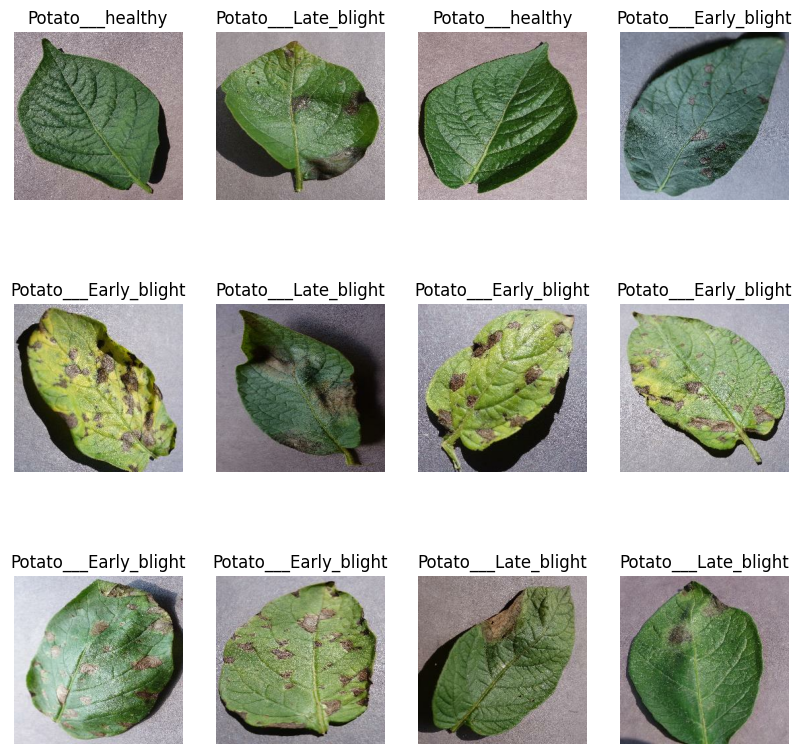

In [202]:
# data visualisation
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [203]:
EPOCHS = 50
train_size = 0.8
len(datasets)*train_size

54.400000000000006

In [204]:
training_dataset = datasets.take(54)
len(training_dataset)

54

In [205]:
test_dataset = datasets.skip(54)
len(test_dataset)

14

In [206]:
val_dataset_size = 0.1
len(datasets)*val_dataset_size

6.800000000000001

In [207]:
val_dataset = test_dataset.take(6)
test_dataset = test_dataset.skip(6)

In [208]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [209]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(datasets)

In [210]:
len(train_ds)

54

In [211]:
len(val_ds)

6

Cache,Shuffle and prefetch the dataset


In [212]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating a Layer for Resizing and Normalization.Normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256) to make the model training faster and more stable.Useful when the model is used for prediction. At that time someone can supply an image that is not (256,256) and this layer will resize it

In [213]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_size, Image_size),
  layers.Rescaling(1./255),
])

Data Augmentation(add more images using geometric transformations) 

In [214]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

Model Architecture.
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [215]:
channels = 3
input_shape = (Batch_size, Image_size, Image_size, channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [216]:
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_28 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [217]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [218]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4946 - loss: 0.9293 - val_accuracy: 0.6823 - val_loss: 0.6707
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7327 - loss: 0.6020 - val_accuracy: 0.8177 - val_loss: 0.3965
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7839 - loss: 0.4837 - val_accuracy: 0.8385 - val_loss: 0.3485
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8055 - loss: 0.4313 - val_accuracy: 0.8906 - val_loss: 0.3205
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 569s 11s/step - accuracy: 0.8897 - loss: 0.2976 - val_accuracy: 0.9219 - val_loss: 0.1714
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 750ms/step - accuracy: 0.8928 - loss: 0.2941 - val_accuracy: 0.9219 - val_loss: 0.2119
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 928ms/step - accuracy: 0.9461 - loss: 0.1656 - val_accuracy: 0.9740 - val_loss: 0.1062
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 889ms/step - accuracy: 0.9482 - loss: 0.1248 - val_accuracy: 0.9167 

In [219]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 1.0000 - loss: 1.5202e-04


In [220]:
scores

[0.00014236208517104387, 1.0]

In [221]:
history

In [222]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [223]:
history.history['accuracy']

[0.5462962985038757,
 0.7407407164573669,
 0.7789351940155029,
 0.8350694179534912,
 0.9033564925193787,
 0.9079861044883728,
 0.9230324029922485,
 0.9571759104728699,
 0.9548611044883728,
 0.9785879850387573,
 0.9652777910232544,
 0.9809027910232544,
 0.9652777910232544,
 0.9878472089767456,
 0.9803240895271301,
 0.9866898059844971,
 0.9820601940155029,
 0.9924768805503845,
 0.9884259104728699,
 0.9930555820465088,
 0.9913194179534912,
 0.9936342835426331,
 0.9965277910232544,
 0.9994212985038757,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [224]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

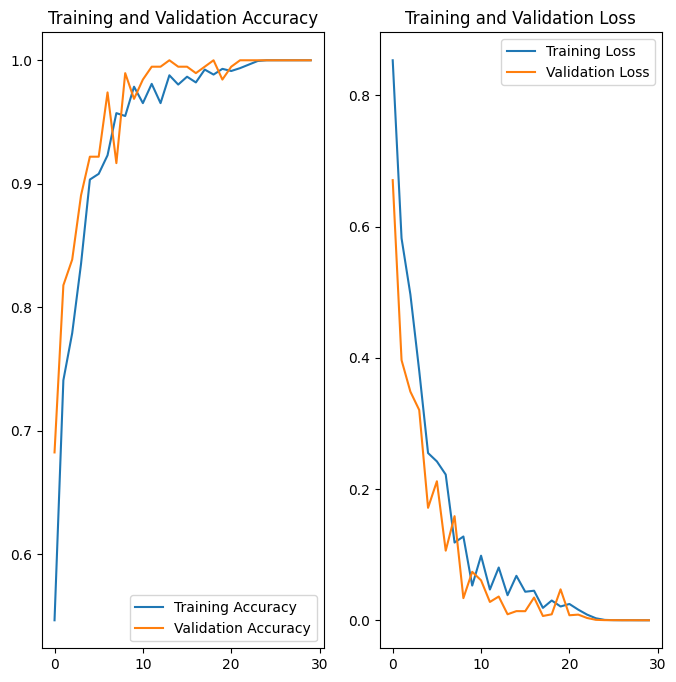

In [226]:
EPOCHS = 30
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Prediction on sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
predicted label: Potato___Early_blight


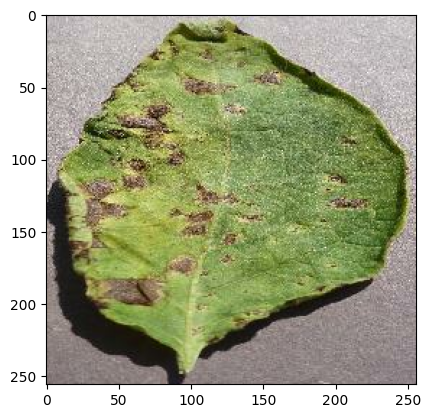

In [227]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [228]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


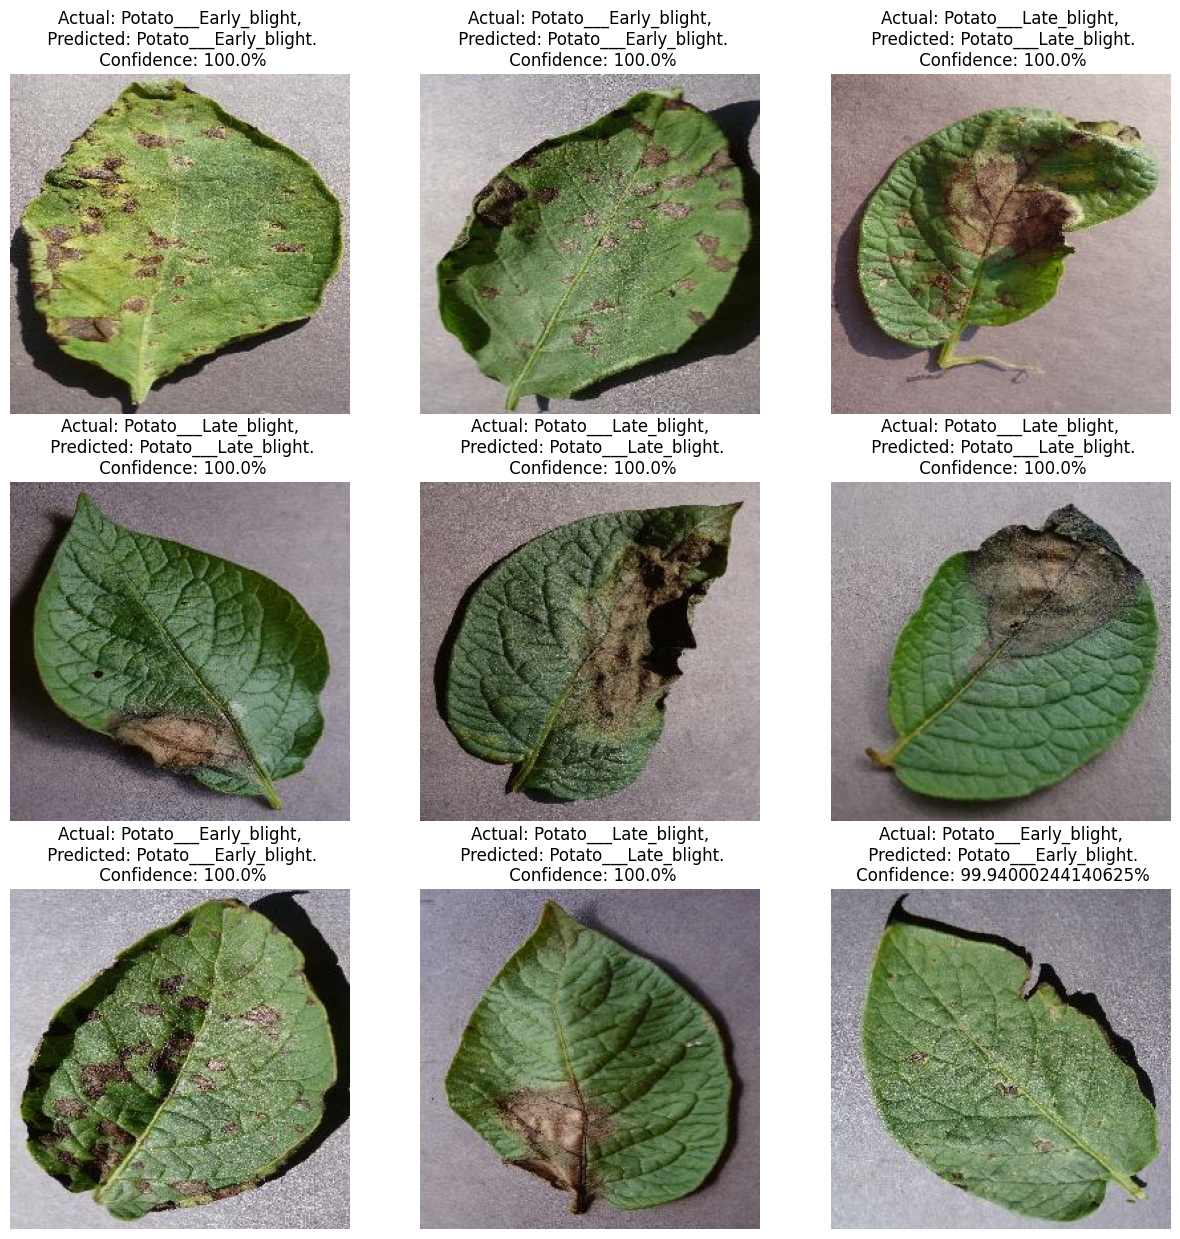

In [229]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [233]:
import os
model_versions = [int(i) for i in os.listdir("../models") if i.isdigit()]
model_version = max(model_versions + [0]) + 1
model.save(f"../models/{model_version}.keras")  # Use `.keras` for the recommended Keras format
